In [1]:
import tf_keras as keras
import tf_keras.layers as layers

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "../data/Pistachio_Image_Dataset",
    image_size=(224, 224),
    batch_size=16,
    validation_split=0.2,
    subset="both",
    seed=42
)

Found 2148 files belonging to 2 classes.
Using 1719 files for training.
Using 429 files for validation.


2025-08-06 11:06:38.523882: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-08-06 11:06:38.523904: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-08-06 11:06:38.523914: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-08-06 11:06:38.523926: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-06 11:06:38.523934: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
import tensorflow as tf
import tensorflow_hub as hub

kaggle_efficientb0_base = hub.KerasLayer('https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-feature-vector/versions/1')

/Users/jurepi/Work/Study/hm-dl/.venv/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [3]:
inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = kaggle_efficientb0_base(x)
x = layers.Dense(128, activation='softmax')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(
    optimizer=rmsprop,
    loss='binary_crossentropy', 
    metrics=['accuracy'])

hist = model.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30


2025-08-06 11:06:42.963985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


108/108 [==============================] - 7s 36ms/step - loss: 0.6900 - accuracy: 0.5713 - val_loss: 0.6867 - val_accuracy: 0.5431
Epoch 2/30
108/108 [==============================] - 2s 21ms/step - loss: 0.6811 - accuracy: 0.5812 - val_loss: 0.6788 - val_accuracy: 0.5431
Epoch 3/30
108/108 [==============================] - 2s 21ms/step - loss: 0.6713 - accuracy: 0.5823 - val_loss: 0.6694 - val_accuracy: 0.5455
Epoch 4/30
108/108 [==============================] - 2s 22ms/step - loss: 0.6613 - accuracy: 0.6422 - val_loss: 0.6578 - val_accuracy: 0.7343
Epoch 5/30
108/108 [==============================] - 2s 21ms/step - loss: 0.6491 - accuracy: 0.8051 - val_loss: 0.6432 - val_accuracy: 0.8788
Epoch 6/30
108/108 [==============================] - 2s 21ms/step - loss: 0.6359 - accuracy: 0.8871 - val_loss: 0.6302 - val_accuracy: 0.9114
Epoch 7/30
108/108 [==============================] - 2s 21ms/step - loss: 0.6251 - accuracy: 0.9034 - val_loss: 0.6204 - val_accuracy: 0.9207
Epoch 8/30

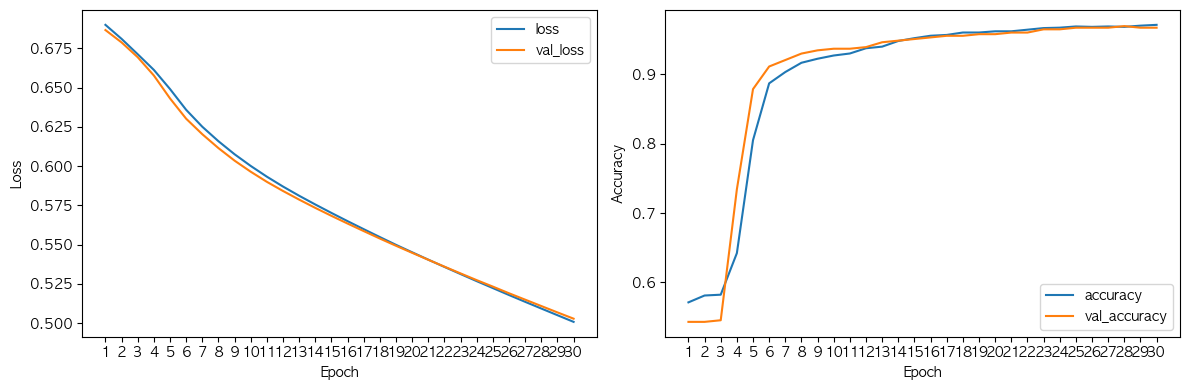

In [4]:
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # 맥OS용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

epochs = 30
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(range(1, epochs+1), hist.history["loss"], label="loss")
axs[0].plot(range(1, epochs+1), hist.history["val_loss"], label="val_loss")
axs[0].set_xticks(range(1, epochs+1))
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(range(1, epochs+1), hist.history["accuracy"], label="accuracy")
axs[1].plot(range(1, epochs+1), hist.history["val_accuracy"], label="val_accuracy")
axs[1].set_xticks(range(1, epochs+1))
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

In [5]:
# 현재 학습 상태 확인
print("=== 최종 학습 결과 ===")
if 'hist' in locals():
    final_train_acc = hist.history['accuracy'][-1]
    final_val_acc = hist.history['val_accuracy'][-1]
    
    print(f"훈련 정확도: {final_train_acc:.1%}")
    print(f"검증 정확도: {final_val_acc:.1%}")
    
    # 과적합 체크
    overfitting = final_train_acc - final_val_acc
    print(f"과적합 정도: {overfitting:.1%}")
    
    if overfitting > 0.1:  # 10% 이상 차이
        print("⚠️ 약간의 과적합 발생")
    else:
        print("✅ 좋은 일반화 성능")
        

# 베스트 검증 정확도
best_val_acc = max(hist.history['val_accuracy'])
best_epoch = hist.history['val_accuracy'].index(best_val_acc) + 1
print(f"\n최고 검증 정확도: {best_val_acc:.1%} (Epoch {best_epoch})")

=== 최종 학습 결과 ===
훈련 정확도: 97.1%
검증 정확도: 96.7%
과적합 정도: 0.4%
✅ 좋은 일반화 성능

최고 검증 정확도: 97.0% (Epoch 28)
